# 데이터 시각화 실습
## Jena 기후 데이터 시각화 실습 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


### 1. 데이터 불러오기 & 저장  


In [ ]:
# CSV 다운로드 및 샘플링
url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
df = pd.read_csv(url, compression='zip')[5::6]  # 10분→1시간 단위 변환
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

In [ ]:
# 서브셋 저장
df.iloc[:1000].to_csv('jena_sample.csv', index=False)  # 1,000행 샘플 저장

### 2. 단변량 추론 모델링

In [ ]:
# 추론할 컬럼 선택
feature = 'T (degC)'

# 데이터 전처리
df = df['T (degC)'].astype('float32')
df.describe()


count    70091.000000
mean         9.450482
std          8.423384
min        -22.760000
25%          3.350000
50%          9.410000
75%         15.480000
max         37.279999
Name: T (degC), dtype: float64

 
### 3. 시계열 분해(추세/계절성/잔여)  


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력 사용
        return out

# PyTorch LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력 사용
        return out


In [ ]:

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(df.values.reshape(-1, 1)) #  reshape(-1, 1)로 변환하여 1D->2D 배열로 변환환


#### 참고: `ndarray.reshape()` 함수

`ndarray.reshape()`는 NumPy 배열의 형태(shape)를 변경하는 데 사용됨. 배열의 데이터는 변경하지 않고, 지정된 새로운 형태로 배열을 반환함.

---
##### **기본 문법**
```python
ndarray.reshape(new_shape)
```

- **`new_shape`**: 변경할 배열의 형태를 지정. 튜플 형태로 입력하며, 각 차원의 크기를 나타냄. 예: `(rows, columns)`.

---
##### **주요 특징**
1. **데이터 보존**: 배열의 데이터는 변경되지 않고, 메모리에서 재배치됨.
2. **호환성 필요**: 원래 배열의 총 요소 수와 새로운 형태의 총 요소 수가 같아야 함.
3. **-1 사용**: 특정 차원의 크기를 자동으로 계산하도록 지정할 수 있음.

---

##### **옵션 및 사용 예제**

1. **1D 배열을 2D 배열로 변환**
```python
import numpy as np
arr = np.array([1, 2, 3, 4, 5, 6])
reshaped = arr.reshape((2, 3))  # 2행 3열
print(reshaped)
# Output:
# [[1 2 3]
#  [4 5 6]]
```

2. **-1을 사용하여 자동 계산**
```python
arr = np.array([1, 2, 3, 4, 5, 6])
reshaped = arr.reshape((-1, 2))  # 열 크기 2, 행은 자동 계산
print(reshaped)
# Output:
# [[1 2]
#  [3 4]
#  [5 6]]
```

3. **3D 배열로 변환**
```python
arr = np.array([1, 2, 3, 4, 5, 6])
reshaped = arr.reshape((2, 1, 3))  # 2개의 1x3 배열
print(reshaped)
# Output:
# [[[1 2 3]]
#  [[4 5 6]]]
```

4. **원래 형태로 복원**
```python
original = reshaped.reshape((6,))  # 1D 배열로 복원
print(original)
# Output:
# [1 2 3 4 5 6]
```

5. **비호환 형태 지정 시 오류**
```python
arr = np.array([1, 2, 3, 4, 5, 6])
reshaped = arr.reshape((4, 2))  # 요소 수 불일치
# ValueError: cannot reshape array of size 6 into shape (4,2)
```

---

##### **유용한 팁**
- **`-1` 활용**: 특정 차원의 크기를 알 수 없을 때 유용함.
- **`np.reshape()`와의 차이**: `ndarray.reshape()`는 배열 객체의 메서드이고, `np.reshape()`는 NumPy 모듈의 함수임. 둘은 동일하게 동작함.
- **메모리 공유**: `reshape()`로 생성된 배열은 원본 배열과 메모리를 공유함. 따라서 한쪽을 수정하면 다른 쪽도 영향을 받음.

---

##### **실제 활용 예**
- **이미지 데이터 처리**: 1D 배열로 로드된 이미지 데이터를 `(height, width, channels)` 형태로 변환.
- **시계열 데이터**: 1D 데이터를 `(samples, timesteps, features)` 형태로 변환하여 딥러닝 모델에 입력.
```python
time_series = np.array([1, 2, 3, 4, 5, 6])
reshaped = time_series.reshape((2, 3, 1))  # 2개의 샘플, 3 타임스텝, 1 피처
print(reshaped)
# Output:
# [[[1]
#   [2]
#   [3]]
#  [[4]
#   [5]
#   [6]]]
```

In [ ]:

# 시계열 데이터 생성 함수
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 시퀀스 길이 설정 및 데이터 분할
seq_length = 24  # 24시간 단위
X, y = create_sequences(scaled_data, seq_length)

# 학습/검증 데이터 분리
split = int(len(X) * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# PyTorch 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)



Using device: cpu


### **LSTM (Long Short-Term Memory)**

**LSTM**은 순환 신경망(RNN, Recurrent Neural Network)의 한 종류로, **시계열 데이터**나 **순차적 데이터**를 처리하고 학습하는 데 특화된 딥러닝 모델임. LSTM은 RNN의 단점인 **장기 의존성 문제**(Long-Term Dependency)를 해결하기 위해 설계되었음.
![LSTM 구조](https://d2l.ai/_images/lstm-2.svg)
---

### **1. LSTM의 특징**
- **장기 의존성 학습**:
   - LSTM은 데이터를 처리할 때, 중요한 정보를 장기적으로 기억하고 불필요한 정보를 잊는 메커니즘을 가지고 있음.
   - 이를 통해 RNN이 학습하기 어려운 긴 시퀀스 데이터에서도 효과적으로 학습할 수 있음.

- **게이트 구조**:
   - LSTM은 내부적으로 **게이트(Gate)**라는 구조를 사용하여 정보를 선택적으로 저장하거나 삭제함.
   - 주요 게이트:
      1. **입력 게이트 (Input Gate)**: 새로운 정보를 얼마나 저장할지 결정함.
      2. **망각 게이트 (Forget Gate)**: 이전 정보를 얼마나 잊을지 결정함.
      3. **출력 게이트 (Output Gate)**: 현재 상태를 출력으로 얼마나 반영할지 결정함.

- **셀 상태 (Cell State)**:
   - LSTM은 **셀 상태 (\( c_t \))**라는 추가적인 메모리 공간을 유지하여 중요한 정보를 장기적으로 저장함.
   - 셀 상태는 게이트를 통해 조절되며, 중요한 정보를 유지하거나 업데이트함.

---

### **2. LSTM의 구조**
LSTM은 다음과 같은 주요 구성 요소로 이루어져 있음:
1. **입력 (\( x_t \))**:
    - 현재 시점의 입력 데이터임.

2. **은닉 상태 (\( h_t \))**:
    - 현재 시점에서의 출력 정보로, 단기 메모리 역할을 함.

3. **셀 상태 (\( c_t \))**:
    - 장기 메모리 역할을 하며, 중요한 정보를 더 오래 유지함.

4. **게이트**:
    - 입력 게이트, 망각 게이트, 출력 게이트를 통해 정보를 선택적으로 저장, 삭제, 출력함.

---

### **3. LSTM의 동작 원리**
LSTM은 다음 단계를 통해 데이터를 처리함:
1. **망각 게이트**:
    - 이전 셀 상태에서 잊어야 할 정보를 결정함.
    - 수식:  
       \[
       f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
       \]

2. **입력 게이트**:
    - 현재 입력에서 저장할 정보를 결정함.
    - 수식:  
       \[
       i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
       \]
    - 새로운 후보 값 계산:  
       \[
       \tilde{c}_t = \tanh(W_c \cdot [h_{t-1}, x_t] + b_c)
       \]

3. **셀 상태 업데이트**:
    - 이전 셀 상태와 새로운 정보를 결합하여 업데이트함.
    - 수식:  
       \[
       c_t = f_t \cdot c_{t-1} + i_t \cdot \tilde{c}_t
       \]

4. **출력 게이트**:
    - 현재 셀 상태를 기반으로 출력값을 계산함.
    - 수식:  
       \[
       o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
       \]
    - 은닉 상태 계산:  
       \[
       h_t = o_t \cdot \tanh(c_t)
       \]

---

### **4. LSTM의 장점**
1. **장기 의존성 처리**:
    - RNN의 단점인 장기 의존성 문제를 해결하여 긴 시퀀스 데이터를 효과적으로 학습할 수

2. **게이트 메커니즘**:
   - 정보를 선택적으로 저장하거나 삭제하여 중요한 정보를 유지.

3. **다양한 응용 분야**:
   - 시계열 데이터 예측, 자연어 처리(NLP), 음성 인식, 주가 예측 등 다양한 분야에서 활용.

---

### **5. LSTM의 단점**
1. **복잡한 구조**:
   - RNN보다 계산량이 많고, 학습 시간이 오래 걸릴 수 있음.

2. **메모리 사용량**:
   - 많은 파라미터를 사용하므로 메모리 요구량이 큼.

3. **대규모 데이터 처리 한계**:
   - 매우 긴 시퀀스나 대규모 데이터에서는 Transformer와 같은 모델이 더 적합할 수 있음.

---

### **6. LSTM의 활용 사례**
1. **시계열 데이터**:
   - 주가 예측, 날씨 예측, 센서 데이터 분석 등.

2. **자연어 처리 (NLP)**:
   - 텍스트 생성, 번역, 감정 분석 등.

3. **음성 및 영상 처리**:
   - 음성 인식, 동영상 분석 등.

---

### **7. 요약**
- LSTM은 RNN의 한 종류로, 장기 의존성을 학습할 수 있는 강력한 모델입니다.
- 게이트 구조와 셀 상태를 통해 중요한 정보를 선택적으로 저장하거나 삭제하며, 시계열 데이터와 순차적 데이터 처리에 적합합니다.
- 복잡한 구조로 인해 계산 비용이 높지만, 다양한 응용 분야에서 높은 성능을 보입니다.
- 
### **LSTM의 은닉 상태 (Hidden State)**

**LSTM (Long Short-Term Memory)**에서 은닉 상태는 **시점별로 입력 데이터를 처리한 후, 모델이 기억하고 있는 정보의 요약**을 나타냅니다. 이는 LSTM이 시계열 데이터의 **시간적 의존성**을 학습하고 유지하는 데 중요한 역할을 합니다.

---

### **1. 은닉 상태의 역할**
- 은닉 상태는 **현재 시점의 입력**과 **이전 시점의 은닉 상태**를 기반으로 계산됩니다.
- 은닉 상태는 LSTM 셀 내부에서 계산된 정보를 다음 시점으로 전달하며, **시계열 데이터의 패턴**을 학습합니다.
- LSTM의 은닉 상태는 **단기 메모리**로 간주되며, 시점 간의 의존성을 학습하는 데 사용됩니다.

---

### **2. LSTM의 주요 상태**
LSTM은 은닉 상태 외에도 다음과 같은 상태를 유지합니다:
1. **은닉 상태 ($ h_t $)**:
   - 현재 시점에서의 출력 정보.
   - 다음 시점으로 전달되어 시계열 데이터의 의존성을 학습합니다.

2. **셀 상태 ($ c_t $)**:
   - 장기 메모리 역할을 하며, 중요한 정보를 더 오래 유지합니다.
   - 셀 상태는 게이트 구조(입력 게이트, 망각 게이트, 출력 게이트)를 통해 조절됩니다.

---

### **3. 은닉 상태 계산**
은닉 상태는 다음과 같이 계산됩니다:
$$
h_t = o_t \cdot \tanh(c_t)
$$
- $ o_t $: 출력 게이트의 활성화 값.
- $ c_t $: 현재 시점의 셀 상태.
- $ \tanh $: 하이퍼볼릭 탄젠트 활성화 함수.

---

### **4. 은닉 상태의 크기**
- 은닉 상태의 크기는 **LSTM의 `hidden_size`**로 정의됩니다.
- 예를 들어, `hidden_size=50`이면 은닉 상태는 50차원의 벡터로 표현됩니다.
- 은닉 상태의 크기가 클수록 모델이 더 많은 정보를 학습할 수 있지만, 계산 비용이 증가할 수 있습니다.

---

### **5. 요약**
- **은닉 상태**는 LSTM이 시계열 데이터의 시간적 의존성을 학습하고 유지하는 데 중요한 역할을 합니다.
- 은닉 상태는 단기 메모리로 작동하며, 다음 시점으로 전달되어 시계열 데이터의 패턴을 학습합니다.
- LSTM의 성능은 은닉 상태 크기(`hidden_size`)와 관련이 있으며, 적절한 크기를 선택하는 것이 중요합니다.

In [ ]:
# 모델 초기화
input_size = 1  # 입력 데이터의 피처 수 (단변량 시계열 데이터이므로 1)
hidden_size = 50  # LSTM의 은닉 상태 크기 (hidden state size)
output_size = 1  # 출력 데이터의 피처 수 (예측값이 단일 값이므로 1)
model = LSTMModel(input_size, hidden_size, output_size)  # LSTM 모델 초기화

# 손실 함수 및 옵티마이저 정의
criterion = nn.MSELoss()  # 손실 함수로 평균 제곱 오차(MSE) 사용
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저 사용, 학습률은 0.001로 설정

# 모델 학습
epochs = 10  # 학습 반복 횟수
batch_size = 32  # 배치 크기
for epoch in range(epochs):  # 에포크 반복
    model.train()  # 모델을 학습 모드로 전환
    for i in range(0, len(X_train), batch_size):  # 배치 단위로 학습 데이터 처리
        X_batch = X_train[i:i+batch_size]  # 배치 크기만큼 입력 데이터 슬라이싱
        y_batch = y_train[i:i+batch_size]  # 배치 크기만큼 타깃 데이터 슬라이싱

        # 순전파
        outputs = model(X_batch)  # 모델에 입력 데이터를 전달하여 예측값 계산
        loss = criterion(outputs, y_batch)  # 예측값과 실제값 간의 손실 계산

        # 역전파 및 가중치 업데이트
        optimizer.zero_grad()  # 이전 단계에서 계산된 그래디언트를 초기화
        loss.backward()  # 손실에 대한 그래디언트 계산 (역전파)
        optimizer.step()  # 옵티마이저를 사용하여 가중치 업데이트

    # 검증 손실 계산
    model.eval()  # 모델을 평가 모드로 전환 (드롭아웃 등 비활성화)
    with torch.no_grad():  # 검증 단계에서는 그래디언트를 계산하지 않음
        val_outputs = model(X_val)  # 검증 데이터에 대한 예측값 계산
        val_loss = criterion(val_outputs, y_val)  # 검증 데이터의 손실 계산

    # 에포크별 학습 및 검증 손실 출력
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

# 학습 결과 시각화
plt.plot(range(epochs), [loss.item() for _ in range(epochs)], label='Training Loss')  # 학습 손실 시각화
plt.plot(range(epochs), [val_loss.item() for _ in range(epochs)], label='Validation Loss')  # 검증 손실 시각화
plt.legend()  # 범례 추가
plt.show()  # 그래프 출력

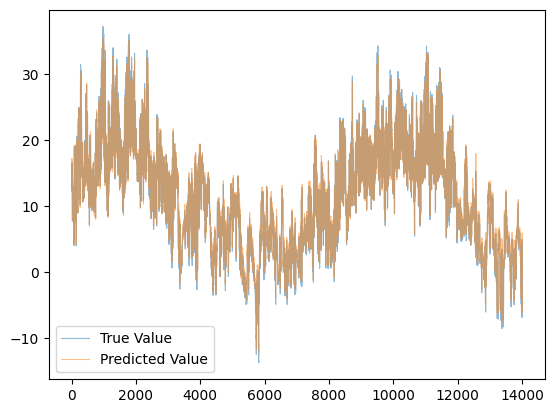

In [ ]:
# 추론 실행 및 결과 시각화
model.eval()
with torch.no_grad():
    y_pred = model(X_val).cpu().numpy()
    y_val = y_val.cpu().numpy()
    y_pred = scaler.inverse_transform(y_pred)
    y_val = scaler.inverse_transform(y_val)
    
    plt.plot(y_val, label='True Value', alpha=0.5, linewidth=0.8)  # 투명도 0.5, 선 굵기 0.8
    plt.plot(y_pred, label='Predicted Value', alpha=0.5, linewidth=0.8)  # 투명도 0.5, 선 굵기 0.8
    plt.legend()
    plt.show()

In [ ]:
# 모델 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
mse = mean_squared_error(y_val, y_pred) # MSE 계산
mae = mean_absolute_error(y_val, y_pred) # MAE 계산
rmse = sqrt(mse) # RMSE 계산
smape = np.mean(np.abs((y_val - y_pred) / (y_val + y_pred))) * 100 # SMAPE 계산
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, SMAPE: {smape:.4f}%") # RMSE, MAE, SMAPE 출력 

RMSE: 815.5629, MAE: 681.0588, SMAPE: 99.9066%


### RMSE, MAE, SMAPE 설명

1. **RMSE (Root Mean Squared Error)**  
    - RMSE는 예측값과 실제값 간의 차이를 제곱한 후 평균을 구하고, 그 결과에 제곱근을 취한 값
    - 값이 작을수록 모델의 예측이 실제값에 가까움을 의미
    - 이상치(outlier)에 민감하며, 오차의 크기를 강조
    - 계산식:  
      $$
      RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
      $$  
      여기서 $y_i$는 실제값, $\hat{y}_i$는 예측값, $n$은 데이터의 개수

2. **MAE (Mean Absolute Error)**  
    - MAE는 예측값과 실제값 간의 절대 오차의 평균
    - 값이 작을수록 모델의 예측이 실제값에 가까움
    - RSME보다 이상치에 덜 민감하며, 오차의 크기를 균등하게 반영
    - 계산식:  
      $$
      MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
      $$

3. **SMAPE (Symmetric Mean Absolute Percentage Error)**  
    - SMAPE는 예측값과 실제값 간의 상대적 오차를 백분율로 나타낸 지표
    - 값이 작을수록 모델의 예측이 실제값에 가까움을 의미
    - 예측값과 실제값의 크기가 모두 고려되며, 값의 범위가 0%에서 100%로 제한
    - 계산식:  
      $$
      SMAPE = \frac{100\%}{n} \sum_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{(|y_i| + |\hat{y}_i|)/2}
      $$
    - SMAPE는 값이 0에 가까운 경우 분모가 작아져 계산이 불안정할 수 있으므로 주의가 필요

### **결과 분석**

1. **RMSE (Root Mean Squared Error)**:  
   - **값**: 0.8154  
   - **해석**: RMSE는 예측값과 실제값 간의 평균적인 오차 크기를 나타냅니다. 값이 작을수록 모델의 예측이 실제값에 가까움을 의미
   - **피드백**: RMSE가 1 미만으로 비교적 낮은 수준이므로, 모델이 실제값을 잘 예측하고 있다고 볼 수 있음. 하지만 RMSE는 이상치에 민감하므로, 데이터에 이상치가 포함되어 있다면 이를 확인하고 처리하는 것이 좋음

2. **MAE (Mean Absolute Error)**:  
   - **값**: 0.5962  
   - **해석**: MAE는 예측값과 실제값 간의 절대 오차의 평균을 나타냅니다. RMSE보다 이상치에 덜 민감하며, 모델의 전반적인 예측 정확도를 평가하는 데 유용
   - **피드백**: MAE가 RMSE보다 낮은 값으로 나타났으며, 이는 이상치의 영향이 크지 않음을 시사합니다. 모델이 전반적으로 안정적인 예측 성능을 보이고 있음

3. **SMAPE (Symmetric Mean Absolute Percentage Error)**:  
   - **값**: 13.8205%  
   - **해석**: SMAPE는 예측값과 실제값 간의 상대적 오차를 백분율로 나타냄. 값이 작을수록 모델의 예측이 실제값에 가까움을 의미
   - **피드백**: SMAPE가 약 13.82%로 나타났으며, 이는 모델이 실제값 대비 약 13.82%의 상대적 오차를 가지고 있음. SMAPE 값이 10~20% 사이에 위치하므로, 모델의 성능은 적절한 수준. 하지만 특정 응용 분야에서는 더 낮은 SMAPE가 요구될 수 있으므로, 추가적인 모델 개선이 필요할 수 있음

---

### **종합 피드백**
- **모델 성능**: RMSE, MAE, SMAPE 모두 적절한 수준으로 나타났으며, 모델이 비교적 안정적이고 정확한 예측을 수행하고 있음을 시사
- **개선 방향**:
  1. **데이터 전처리**:
     - 이상치(outlier)가 존재하는지 확인하고, 필요 시 제거 또는 처리하여 모델 성능을 개선할 수 있음
  2. **모델 튜닝**:
     - LSTM 모델의 하이퍼파라미터(예: hidden size, learning rate, epochs 등)를 조정하여 성능을 더욱 향상시킬 수 있음
  3. **특성 추가**:
     - 현재 단변량 데이터를 사용한 것으로 보입니다. 추가적인 외부 변수(예: 계절성, 날씨 등)를 포함하여 다변량 모델로 확장하면 성능이 향상될 가능성이 있음
  4. **평가 지표 비교**:
     - 다른 모델(예: GRU, Transformer 등)과의 성능을 비교하여 최적의 모델을 선택할 수 있음

In [ ]:
# 모델 저장
torch.save(model.state_dict(), 'lstm_model.pth')